In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

### Import data

In [2]:
def strip_months(x):
    return x.strip('months').strip()

In [3]:
def p2f(x):
    return x.strip('%')

In [4]:
def strip_years(x):
    return re.sub(r'years|year','',x).strip()


In [5]:
loan_data = pd.read_csv("C:\\Users\\Gaurav\\Desktop\\Happy Money\\LoanStats_2015.csv", sep=',',header=1,
                        skiprows=0, nrows=421095, 
                        converters={'int_rate':p2f,'revol_util':p2f,'term':strip_months,'emp_length':strip_years},
                        parse_dates=["last_pymnt_d","next_pymnt_d","last_credit_pull_d","debt_settlement_flag_date","settlement_date","issue_d","earliest_cr_line","hardship_start_date","hardship_end_date","payment_plan_start_date"],
                       low_memory=False)

                                           

In [6]:
loan_data.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,12000,12000,12000.0,60,9.80,253.79,B,B3,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN
1,NaN,NaN,25000,25000,25000.0,36,5.32,752.87,A,A1,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN


### drop columns with not even single value

In [7]:
missing_df = loan_data.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']==loan_data.shape[0]]
drop_cols=missing_df.column_name.values.tolist()
print("shape of loan_data before:",loan_data.shape)
loan_data=loan_data.drop(drop_cols,axis=1)
print("shape of loan_data after:",loan_data.shape)

shape of loan_data before: (421095, 145)
shape of loan_data after: (421095, 131)


In [8]:
#revol_util,term,int_rate 
loan_data[['revol_util','int_rate']] = loan_data[['revol_util','int_rate']].apply(pd.to_numeric,downcast='float')

### drop columns with 1 constant value

In [9]:
# has only constant value for all the records
loan_data=loan_data.drop(["disbursement_method","policy_code"],axis=1) 

In [10]:
loan_data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421095 entries, 0 to 421094
Columns: 129 entries, loan_amnt to settlement_term
dtypes: datetime64[ns](10), float32(2), float64(54), int64(39), object(24)
memory usage: 863.5 MB


In [11]:
for dtype in ['float32','float64','int64','object','datetime64']:
    selected_dtype = loan_data.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

Average memory usage for float32 columns: 1.07 MB
Average memory usage for float64 columns: 3.15 MB
Average memory usage for int64 columns: 3.13 MB
Average memory usage for object columns: 21.17 MB
Average memory usage for datetime64 columns: 2.92 MB


In [12]:
# We're going to be calculating memory usage a lot,
# so we'll create a function to save us some time!
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

In [13]:
loan_data_int = loan_data.select_dtypes(include=['int64'])
loan_data_int.shape

(421095, 39)

In [14]:
converted_loan_data_int = loan_data_int.apply(pd.to_numeric,downcast='unsigned')
print(mem_usage(loan_data_int))
print(mem_usage(converted_loan_data_int))
loan_data[converted_loan_data_int.columns] = converted_loan_data_int
compare_ints = pd.concat([loan_data_int.dtypes,converted_loan_data_int.dtypes],axis=1)
compare_ints.columns = ['before','after']
compare_ints.apply(pd.Series.value_counts)

125.30 MB
29.72 MB


,before,after
uint8,NaN,24.0
uint16,NaN,5.0
uint32,NaN,10.0
int64,39.0,NaN


In [15]:
loan_data_float = loan_data.select_dtypes(include=['float32','float64'])
loan_data_float.shape

(421095, 56)

In [16]:
converted_loan_data_float = loan_data_float.apply(pd.to_numeric,downcast='float')
print(mem_usage(loan_data_float))
print(mem_usage(converted_loan_data_float))
loan_data[converted_loan_data_float.columns] = converted_loan_data_float

compare_floats = pd.concat([loan_data_float.dtypes,converted_loan_data_float.dtypes],axis=1)
compare_floats.columns = ['before','after']
compare_floats.apply(pd.Series.value_counts)

176.70 MB
89.96 MB


,before,after
float32,2,56.0
float64,54,NaN


In [17]:
#### only object datatypes are yet to be optimized
#loan_data_datetime64 = loan_data.select_dtypes(include=['datetime64'])

In [18]:
#optimized_loan_data = pd.concat([converted_loan_data_int, converted_loan_data_float,loan_data_datetime64], axis=1)

### missing values

In [19]:
missing_df = loan_data.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')


#### hardship related variables
-  from the analysis, I understood that the hardship records are maintained only for loans/people with hardship status values "COMPLETED","BROKEN","ACTIVE".
-  All the other records doesn't have values for any of the hardship related variables
    -  hardship_amount
    -  hardship_dpd  
    -  hardship_end_date
    -  hardship_last_payment_amount
    -  hardship_length
    -  hardship_loan_status
    -  hardship_payoff_balance_amount
    -  hardship_reason
    -  hardship_start_date
    -  hardship_status
    -  hardship_type
-  have to come up with a default value for all the above variables 

In [20]:
missing_df =missing_df.loc[~missing_df.variable_name.isin(["hardship_amount","hardship_dpd","hardship_flag","hardship_last_payment_amount","hardship_length","hardship_loan_status","hardship_payoff_balance_amount",
"hardship_reason","hardship_start_date","hardship_end_date","hardship_status","hardship_type"])]
missing_df

,variable_name,missing_count
92,num_rev_accts,1
21,dti,2
45,last_credit_pull_d,9
18,title,132
30,revol_util,162
42,last_pymnt_d,294
81,mths_since_recent_bc,3798
72,bc_open_to_buy,3963
73,bc_util,4227
100,percent_bc_gt_75,4239


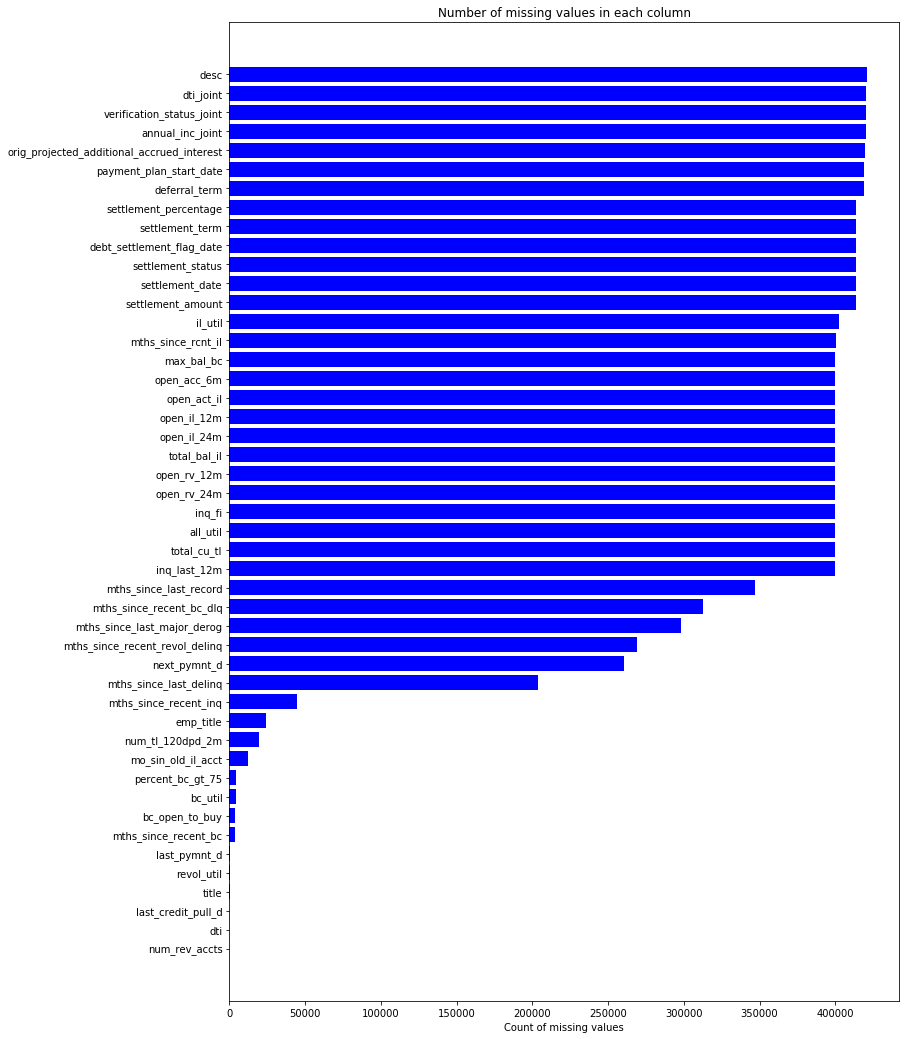

In [21]:
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.variable_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [22]:
loan_data_copy=loan_data.copy()

In [23]:
print("val count:",loan_data.application_type.value_counts())
print("NA #",loan_data.application_type.isnull().sum())
temp5=loan_data.loc[loan_data.application_type=="Joint App", ["verification_status_joint","application_type"]]
print("no null",temp5.isnull().sum())


val count: Individual    420584
Joint App        511
Name: application_type, dtype: int64
NA # 0
no null verification_status_joint    0
application_type             0
dtype: int64


In [24]:
loan_data.desc.isnull().sum()

421050

In [25]:
dummies_list=['debt_settlement_flag','pymnt_plan','hardship_flag','application_type','home_ownership','initial_list_status','term','verification_status',
             'grade','loan_status','purpose']
dummy_df = pd.get_dummies(loan_data[dummies_list])
loan_data_copy[dummy_df.columns] = dummy_df
loan_data_copy=loan_data_copy.drop(dummies_list,axis=1)

In [26]:
loan_data_copy.emp_length.value_counts()

10+    141521
2       37497
< 1     34340
3       33430
1       27473
5       24930
4       24506
n/a     23817
8       21560
7       18414
6       16838
9       16769
Name: emp_length, dtype: int64

In [27]:
#hardship_status - 3 levels
#hardship_loan_status - 4 levels
#settlement_status - ACTIVE, COMPLETE, BROKEN
#sub_grade - multiple levels
#hardship_reason 9 levels
#title - multiple levels
#emp_title - multiple levels
#zip_code - multiple levels
#addr_state - multiple levels
#######
#verification_status_joint  -- applied only for joint application

###

 # 'emp_length',
  #'desc',,

In [28]:
loan_data_object = loan_data_copy.select_dtypes(include=['object'])
loan_data_object.columns

Index(['sub_grade', 'emp_title', 'emp_length', 'desc', 'title', 'zip_code',
       'addr_state', 'verification_status_joint', 'hardship_type',
       'hardship_reason', 'hardship_status', 'hardship_loan_status',
       'settlement_status'],
      dtype='object')

In [29]:
print(mem_usage(loan_data))
print(mem_usage(loan_data_copy))

681.16 MB
416.40 MB


In [30]:
#optimized_loan_data = loan_data.copy()
#optimized_loan_data[converted_loan_data_int.columns] = converted_loan_data_int
#optimized_loan_data[converted_loan_data_float.columns] = converted_loan_data_float

#### SET A:
-  What is the monthly total loan volume in dollars and what is the monthly average loan size?
-  What are the default rates by Loan Grade?
-  Is Lending Club charging an appropriate interest rate for the risk?
-  What are some of the predictors of loan default

In [31]:
#loan_amnt , issue_m
loan_data_copy['issue_m'] = loan_data_copy['issue_d'].dt.month
temp_df1 = loan_data_copy[['issue_m','loan_amnt']]
r1=temp_df1.groupby("issue_m").sum().reset_index()
fig, ax = plt.subplots()
ax.set_xlabel('Month')
ax.set_ylabel('Total Loan Issued')
ax.set_title('Monthly Loan Issued')
plt.xscale('linear')
plt.plot(r1.issue_m,r1.loan_amnt)

In [32]:
#what is the monthly total loan volume in dollars 
r2=temp_df1.groupby("issue_m").mean().reset_index()

fig, ax = plt.subplots()
ax.set_xlabel('Month')
ax.set_ylabel('Average Loan Issued')
ax.set_title('Monthly Avg Loan Issued')
plt.xscale('linear')
plt.plot(r2.issue_m,r2.loan_amnt)

In [33]:
def default_rate(loan_status_group):
    # input is a DataFrame of group values
    #print("$$$$$",loan_status_group)
    n_defaults=len(loan_status_group.loc[loan_status_group.loan_status=="Default"])
    #print("$$$",n_defaults)
    n_total = len(loan_status_group)
    #print("@@@",n_total)
    return (n_defaults/n_total)*100
    

    

In [34]:
loan_data["loan_status"].value_counts()

Fully Paid            196814
Current               151713
Charged Off            63845
Late (31-120 days)      4905
In Grace Period         2757
Late (16-30 days)       1052
Default                    9
Name: loan_status, dtype: int64

In [35]:
#What are the default rates by Loan Grade?

r3 = loan_data[["loan_status","grade"]]
r3 = r3.groupby(["grade"]).apply(default_rate).reset_index()
r3.columns = ['grade', 'default_rate']
r3
            


,grade,default_rate
0,A,0.001364
1,B,0.000850
2,C,0.003318
3,D,0.001596
4,E,0.005723
5,F,0.000000
6,G,0.000000


In [36]:
#Is Lending Club charging an appropriate interest rate for the risk?

r4 = loan_data[["int_rate","sub_grade"]]
r4 = r4.groupby(["sub_grade"]).mean().reset_index()
r4 = r4.sort_values(by='int_rate')
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlabel('Loan Grade')
ax.set_ylabel('Interest Rate')
ax.set_title('Loan Grade vs Interest Rate')
plt.plot(r4.sub_grade,r4.int_rate)

ValueError: could not convert string to float: 'G5'

In [ ]:
#What are some of the predictors of loan defaults

#### Set B

-  Data is often messy please review and QA the dataset and summarize your thoughts on any structural
issues:
-  Is there missing data? Is the missing data random or structured? Are some attributes missing more
than others?
-  Are there any glaringly erroneous data values?